<a href="https://colab.research.google.com/github/makagan/TRISEP_Tutorial/blob/main/Exercises/5.VariationalAutoEncoder-MNIST-SOLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Variational Autoencoder 


As discussed in the lecture, one of the generative modeling techniques is the variational autoencoder (VAE), 
that takes as input a data point $x$ and builds
a probability distribution over latent variables $z$, i.e. the posterior $p_\phi(z|x)$. 
We use a neural network to predict the parameters of this distribution for each $x$.
For a Gaussian posterior we predict mean and variance, so $\phi= \{\mu(x), \sigma^2(x) \}$.

We can sample from this posterior distribution $z \sim p_\phi(z|x)$, and use this sample
to randomly generate a new data point that reconstructs the input. We do this by using another neural network
to learn the parameters of the likelihood $p_\theta(x|z)$, where for instance the 
likelihood is also chosen to be Gaussian and neural network can learn the mean $\theta \mu(x)$
(we often assume the gaussian variance is $1$ for simplicity).

The training goal is to make the reconstruction as close as possible to the original, whilst also 
minimizing the distance between the posterior and the prior assumed to be Normal $N(0,1)$.

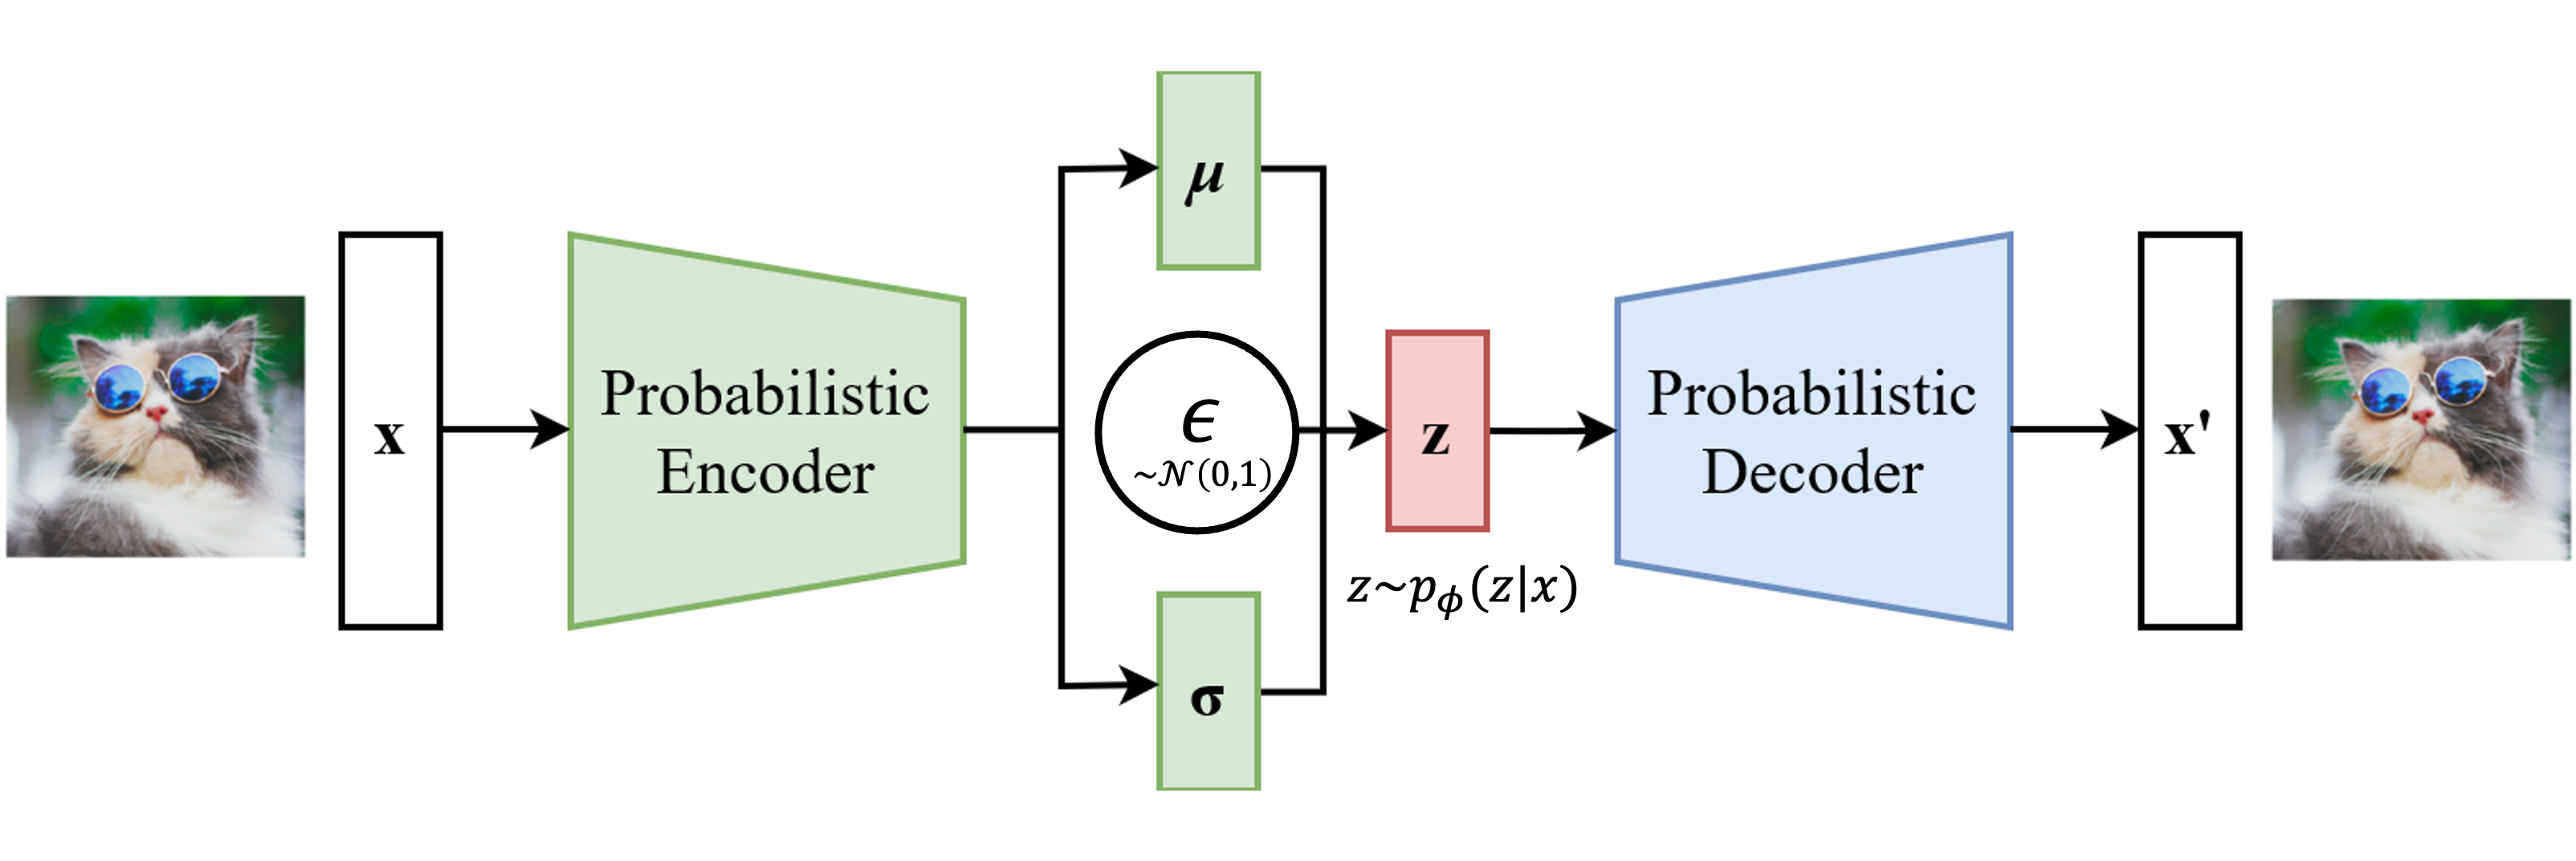

## Step 0: Some imports

In [1]:
import numpy as np

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

## Step 1: Building a VAE with PyTorch

In this step, you will develop an VAE module capable of encoding and decoding images from the MNIST dataset.

### VAE Module

Like the Autoencoder, the VAE consists of two main components, an encoder and a decoder, but in the VAE case they are probabilistic

#### Task 1: Implement the Sample function

We will take the encoder and decoder models from the autoencoder tutorial, with two changes: 

(a) we removed the Flattening, and moved this operation elsewhere

(b) we have to adjust the number of outputs of the encoder to predict the number of parameters of the posterior. Sicne its guassian, we need both a mean and variance for every latent dimension

The operations of the model are now split into an encode, decode and sample function, where the sample function geenrates a random latent vector from the outputs of the encoder.

Your first task is to implement the sample function:

1. **Sample function**: 
   - This function takes as input the mean and log-variance that the encoder outputs.
   - Use the log-variance to calculate sigma of the gaussian
   - sample a random vector (with the correct shape!) from a normal distribution $N(0,1)$ 
   - Combine the sample with the mean and sigma to for a latent vector

### Task 2: Forward Pass Implementation

Implement the `forward()` method:
1. **Encoding**: Pass the input images through the encoder module to obtain the mean and log variance estimatrs.
2. **Sampling**: Pass the mean and the log-variance to the sample function to get the latent vector
3. **Decoding**: Feed the latent vector into the decoder to reconstruct the images.
4. **Output**: The method should return a tuple containing the reconstructed images, the encoded latent vector, and the estimated parameter mean and log-variance

In [2]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,2*self.latent_dim),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,28*28),
            torch.nn.Sigmoid(),
            #torch.nn.Unflatten(-1,(28,28))
        )

    def sample(self, mu, log_var):
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        return eps*sigma + mu

    def encode(self, x):
        x = self.encoder(x.view(-1, 28*28))
        mu, log_var = x[:,:self.latent_dim], x[:,self.latent_dim:]
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)
            
            
    def forward(self,x):
        mu, log_var = self.encode(x)
        z = self.sample(mu, log_var)
        reco_x = self.decode(z)
        return reco_x.view((-1,28,28)), z, mu, log_var


### Task 2: Loss Function

Implement the KL divergence term of the loss. For a gaussian posterior and a nor prior $N(0,1)$, this term should have the form

$D_{KL} = -0.5*(1+\log{\sigma(x)^2} - \mu^2(x) - \sigma^2(x))$

Don't forget to sum over the different $z$ dimensions, and average over the batch dimension.


In [3]:
def loss_function(x, reco_x, mu, log_var):
    # Reconstruction loss (MSE or BCE)
    reco_loss = torch.nn.functional.mse_loss(x.view(-1, 28,28),reco_x.view(-1, 28,28), reduction='sum') / x.shape[0]

    # KL divergence for two Normal distributions with prior N(0,1)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return reco_loss + kl_loss
    

## Step 2: Import Data 



In [4]:
# when running on Colab
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))


from torch.utils.data import DataLoader
from torch import reshape

batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Step 3: The Training Loop

Write a training loop with your VAE model that trains using mini-batches of size 32 (which is sampled from the train_data_loader) and using the VAE loss defined above. Train for 5k steps with learning rate 1e-3 (with Adam)


In [5]:
def plot(model,sample):
    f,axarr = plt.subplots(1,2)
    with torch.no_grad():
        reco_x, z, mu, log_var = model(sample)
    axarr[0].imshow(sample[0])
    axarr[1].imshow(reco_x[0])
    f.set_tight_layout(True)

0 181.87217712402344


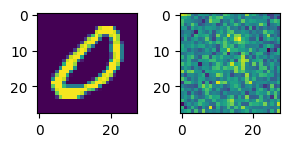

500 42.30389404296875
1000 40.38238525390625


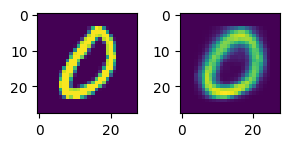

1500 39.73808288574219
2000 38.73273849487305


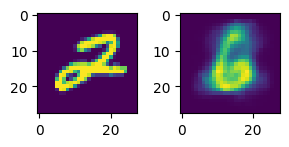

2500 37.879512786865234
3000 36.70903015136719


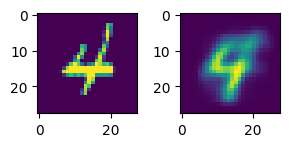

3500 37.33721923828125
4000 35.35074996948242


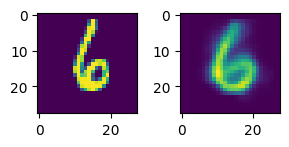

4500 34.99156951904297


In [6]:

def train_vae():
    model = VAE(latent_dim=2)
    opt = torch.optim.Adam(model.parameters(),1e-3)
    
    
    for i in range(5000):
        opt.zero_grad()
        
        x, y = next(iter(train_dataloader))
        
        reco_x, z, mu, log_var = model(x)

        loss = loss_function(x, reco_x, mu, log_var)
        
        loss.backward()
        opt.step()

        
        
        if i % 500 == 0:
            print(i,float(loss))
        if i % 1000 == 0:
            plot(model,x[0].reshape(1,28,28))
            plt.gcf().set_size_inches(3,3)
            plt.show()
    return model
m = train_vae()

# Step 4: Exploring the Latent Space

Sample a mini batch of size 10,000 **with** labels and encode it into the latent space with the
trained encoder. Since it's a 2-D latent space we can easily visualize it. Plot the distribution
of codes as a scatter plot in the $(z_1,z_2)$-plane and color the markers according to the true label

Observe how the individual clusters correspond among other things to the label

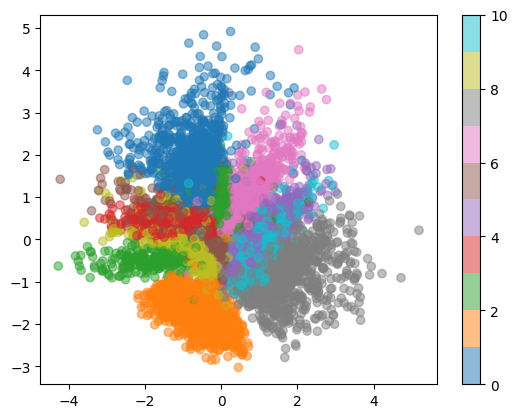

In [7]:
train_dataloader10k = DataLoader(dataset, batch_size=10000, shuffle=True)


def plot_latent_space(model):
    x,y = next(iter(train_dataloader10k))
    with torch.no_grad():
        reco_x, z, mu, log_var = model(x)
    plt.scatter(z[:,0],z[:,1],c = y,cmap = 'tab10', alpha = 0.5, vmin = 0, vmax = 10)
    plt.colorbar()
    
plot_latent_space(m)

# Step 5: Generating new images

To generate new images, we only need the decoder. Sample new latents from the prior $N(0,1)$ and feed those into the decoder. 

Plot a few images, how to they look? 

why do they look that way (Hint, look at the latent space distribution, does it look like the prior?)

What could you do to make these look better?


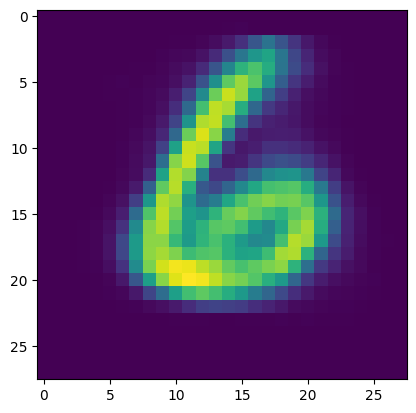

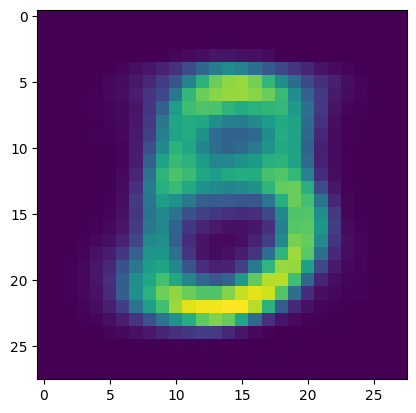

In [8]:
z = torch.randn((1,2))
plt.imshow(m.decoder(z).view(1,28,28).detach()[0])
plt.show()

z = torch.randn((1,2))
plt.imshow(m.decoder(z).view(1,28,28).detach()[0])
plt.show()

# Conditional VAE

If we use the labels in the training to have more control over our sampling process.
So now we will implement a conditional VAE, that also takes and input the label.
We will do this by converting the digit label into a one-hot-vector,
and concatenating this to the input of both the encoder and decoder

In [9]:
class cVAE(torch.nn.Module):
    def __init__(self, latent_dim=2, num_cond_classes=0):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.num_cond_classes = num_cond_classes
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28 + self.num_cond_classes,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,2*self.latent_dim),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim + self.num_cond_classes,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,28*28),
            torch.nn.Sigmoid(),
            #torch.nn.Unflatten(-1,(28,28))
        )

    def sample(self, mu, log_var):
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        return eps*sigma + mu

    def encode(self, x, c):
        one_hot_condition = torch.nn.functional.one_hot(c, num_classes=self.num_cond_classes)
        x = torch.cat((x.view(-1, 28*28), one_hot_condition), dim=-1)
        
        x = self.encoder(x)
        mu, log_var = x[:,:self.latent_dim], x[:,self.latent_dim:]
        return mu, log_var

    def decode(self, z, c):
        one_hot_condition = torch.nn.functional.one_hot(c, num_classes=self.num_cond_classes)
        z = torch.cat((z, one_hot_condition), dim=-1)
        return self.decoder(z)
            
            
    def forward(self,x, c):
        mu, log_var = self.encode(x, c)
        z = self.sample(mu, log_var)
        reco_x = self.decode(z, c)
        return reco_x.view((-1,28,28)), z, mu, log_var

In [10]:
def plot_c(model,sample, label=None):
    f,axarr = plt.subplots(1,2)
    with torch.no_grad():
        if label==None:
            reco_x, z, mu, log_var = model(sample)
        else:
            reco_x, z, mu, log_var = model(sample, label)
    axarr[0].imshow(sample[0])
    axarr[1].imshow(reco_x[0])
    f.set_tight_layout(True)

0 180.77415466308594


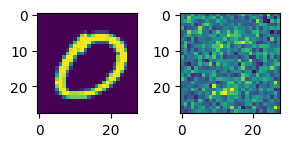

500 33.300331115722656
1000 37.646541595458984


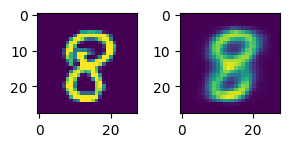

1500 32.57350540161133
2000 31.71099853515625


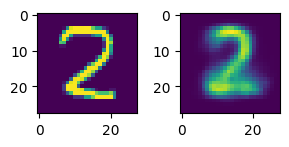

2500 33.6441650390625
3000 32.64849090576172


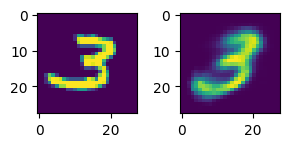

3500 31.65415382385254
4000 30.927095413208008


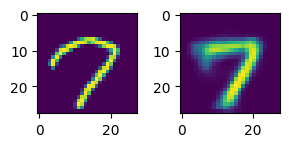

4500 34.1584358215332


In [11]:
def train_cvae():
    model = cVAE(latent_dim=2, num_cond_classes=10)
    opt = torch.optim.Adam(model.parameters(),1e-3)
    
    
    for i in range(5000):
        opt.zero_grad()
        
        x, y = next(iter(train_dataloader))
        
        reco_x, z, mu, log_var = model(x, y)

        loss = loss_function(x, reco_x, mu, log_var)
        
        loss.backward()
        opt.step()

        
        
        if i % 500 == 0:
            print(i,float(loss))
        if i % 1000 == 0:
            plot_c(model,x[0].reshape(1,28,28), y[0].view(1,))
            plt.gcf().set_size_inches(3,3)
            plt.show()
    return model
cm = train_cvae()

# Latent Space

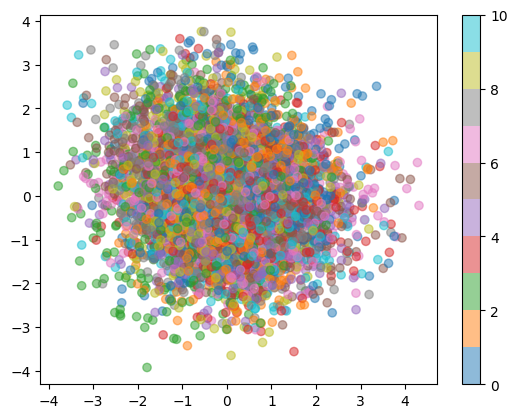

In [12]:
def plot_cond_latent_space(model):
    x,y = next(iter(train_dataloader10k))
    with torch.no_grad():
        reco_x, z, mu, log_var = model(x, y)
    plt.scatter(z[:,0],z[:,1],c = y,cmap = 'tab10', alpha = 0.5, vmin = 0, vmax = 10)
    plt.colorbar()
    
plot_cond_latent_space(cm)

# Sample

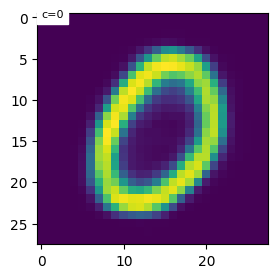

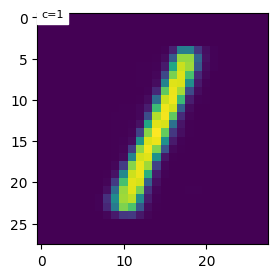

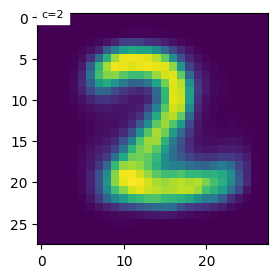

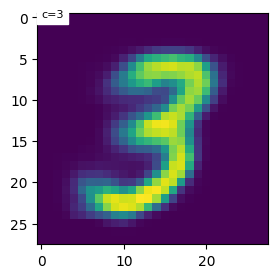

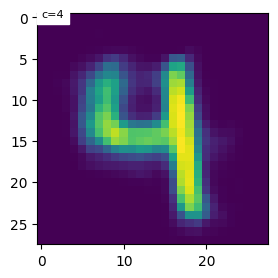

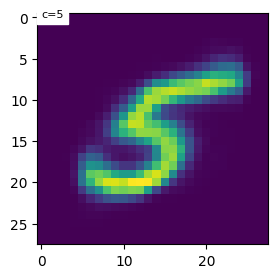

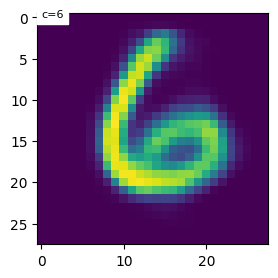

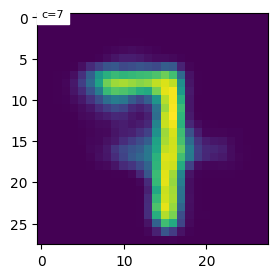

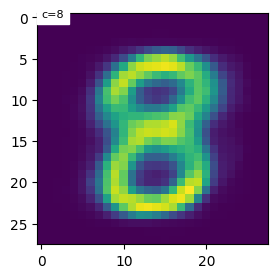

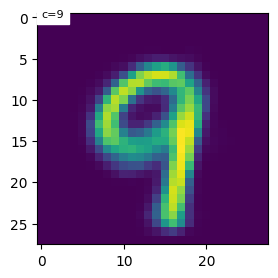

In [13]:
for i in range(10):
    with torch.no_grad():
        z = torch.randn((1,2))
        c = torch.tensor([i])
        #c = torch.distributions.categorical.Categorical(0.1*torch.ones((1,10))).sample()
        xbar = cm.decode(z,c)

    

    f,axarr = plt.subplots(1,1)
    plt.text(0, 0, "c={:d}".format(c[0].numpy()), color='black',
             backgroundcolor='white', fontsize=8)
    axarr.imshow(xbar.view(28,28))
    plt.gcf().set_size_inches(3,3)
    plt.show()
    